In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn import datasets

!pip install pyro-ppl
import pyro.distributions as dist
import pyro
from pyro.infer.autoguide import *
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TracePredictive, EmpiricalMarginal
from torch.distributions import constraints
from pyro import poutine

     |████████████████████████████████| 409kB 2.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [2]:
digits = datasets.load_digits()
data = torch.tensor(digits['data'], dtype=torch.float)
labels = digits['target']

print (data.shape)
print (data)
print (labels.shape)

torch.Size([1797, 64])
tensor([[ 0.,  0.,  5.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 10.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1.,  ...,  6.,  0.,  0.],
        [ 0.,  0.,  2.,  ..., 12.,  0.,  0.],
        [ 0.,  0., 10.,  ..., 12.,  1.,  0.]])
(1797,)


In [3]:
pyro.clear_param_store()

N = len(data)
T = 10

def mix_weights(beta): 
    weights = torch.zeros(beta.shape[0] + 1)
    for t in range(beta.shape[0]):
      weights[t] = beta[t] * torch.prod(1. - beta[:t], dim=0)
    weights[beta.shape[0]] = 1. - torch.sum(weights)
    return weights

def model(data):
    alpha = 1.5
    with pyro.plate("beta_plate", T-1):
      beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("mu_plate", T):
      mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(64), 5 * torch.eye(64)))

    with pyro.plate("data", N):
      z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
      pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(64)), obs=data)

def guide(data):
    kappa = pyro.param('kappa', dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', dist.MultivariateNormal(torch.zeros(64), 5 * torch.eye(64)).sample([T]))
    phi = pyro.param('phi', dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
      q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
      q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(64)))

    with pyro.plate("data", N):
      z = pyro.sample("z", dist.Categorical(phi))

optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=100)

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss))

train(10000)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

/usr/local/lib/python3.6/dist-packages/pyro/infer/svi.py:50: FutureWarning: The `num_samples` argument to SVI is deprecated and will be removed in a future release. Use `pyro.infer.Predictive` class to draw samples from the posterior.
  'samples from the posterior.', FutureWarning)


[iteration 0001] loss: 3932070.8690
[iteration 0501] loss: 1246648.5259
[iteration 1001] loss: 1240557.1944
[iteration 1501] loss: 1246372.5285
[iteration 2001] loss: 1244194.0621
[iteration 2501] loss: 1242435.8747
[iteration 3001] loss: 1244153.6135
[iteration 3501] loss: 1236900.1440
[iteration 4001] loss: 1228360.1388
[iteration 4501] loss: 1230419.5299
[iteration 5001] loss: 1234885.2899
[iteration 5501] loss: 1234478.3864
[iteration 6001] loss: 1231183.3964
[iteration 6501] loss: 1219438.6288
[iteration 7001] loss: 1226284.5297
[iteration 7501] loss: 1224889.4236
[iteration 8001] loss: 1228611.4850
[iteration 8501] loss: 1219372.5360
[iteration 9001] loss: 1224269.5196
[iteration 9501] loss: 1218219.9017

kappa tensor([8.7076, 6.2381, 7.3604, 7.1182, 6.0631, 5.3281, 3.4453, 1.7339, 1.5616],
       grad_fn=<AddBackward0>)
tau tensor([[ 2.2801e-01,  4.0484e-01,  4.3529e+00,  1.1188e+01,  1.1439e+01,
          5.3872e+00,  1.2778e+00,  2.9250e-02, -1.6598e-01,  1.8583e+00,
         

In [4]:
Bayes_Weights = mix_weights(1. / (1. + pyro.param("kappa").detach()))

print (Bayes_Weights)
Bayes_Centers = pyro.param("tau").detach()
# print (Bayes_Centers)

# truncated_Bayes_Weights = Bayes_Weights[Bayes_Weights > 0.03] / sum(Bayes_Weights[Bayes_Weights > 0.03])
# truncated_Bayes_Rates = Bayes_Centers[Bayes_Weights > 0.03]

_, assignments = torch.max(pyro.param("phi").detach(), 1)
print (assignments.shape)
print (assignments[:10])



tensor([0.1030, 0.1239, 0.0925, 0.0838, 0.0845, 0.0810, 0.0970, 0.1223, 0.0828,
        0.1292])
torch.Size([1797])
tensor([6, 0, 9, 9, 8, 3, 6, 5, 7, 6])


In [5]:
from sklearn.manifold import TSNE

tsne = TSNE()

twoD = tsne.fit_transform(data)

print(twoD)

[[-64.56978    18.336487 ]
 [  9.300561  -14.838518 ]
 [ 28.40209    -1.4274122]
 ...
 [ 11.779197    2.6289916]
 [-15.020939   22.781199 ]
 [  9.19622     9.835493 ]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

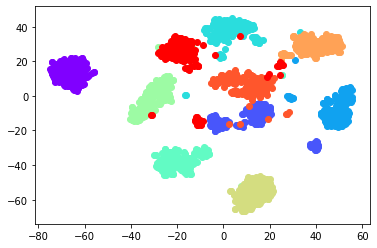

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

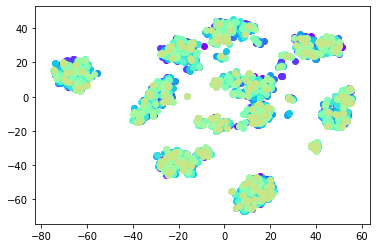

In [6]:
import matplotlib.cm as cm

def plot_clusters(data, labels, color):
    for idx, label in enumerate(np.unique(labels)):
      plt.scatter(data[labels==label, 0], data[labels==label, 1], c=color[idx])
    plt.show()


plot_clusters(twoD, labels, cm.rainbow(np.linspace(0,1,10)))

plot_clusters(twoD, assignments, cm.rainbow(np.linspace(0,1,15)))



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

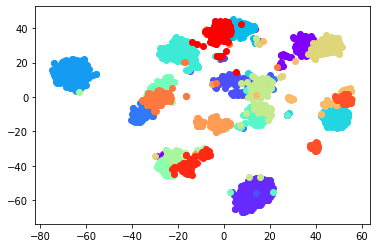

In [9]:
from sklearn.mixture import BayesianGaussianMixture

k = 20
dpmm = BayesianGaussianMixture(n_components=k, weight_concentration_prior=1.5)
dpmm.fit(data)
labels_sklearn = dpmm.predict(data)

plot_clusters(twoD, labels_sklearn, cm.rainbow(np.linspace(0,1,20)))